<a href="https://colab.research.google.com/github/MANUPRIYASINGH/MSWC_FSCIL_Reproduction/blob/main/TCN_FSCIL_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neurobench

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
 

In [1]:
import copy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset

from neurobench.benchmarks import Benchmark
from neurobench.datasets import MSWC
from neurobench.datasets.MSWC_IncrementalLoader import IncrementalFewShot
from tqdm import tqdm

In [2]:
!git clone https://github.com/MANUPRIYASINGH/MSWC_FSCIL_Reproduction.git

Cloning into 'MSWC_FSCIL_Reproduction'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 66 (delta 23), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (66/66), 18.75 MiB | 14.64 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [3]:
cd MSWC_FSCIL_Reproduction/

/content/MSWC_FSCIL_Reproduction


In [4]:
!pip install git+https://github.com/V0XNIHILI/TCN-library.git

  Cloning https://github.com/V0XNIHILI/TCN-library.git to /tmp/pip-req-build-p9i38tdw
  Running command git clone --filter=blob:none --quiet https://github.com/V0XNIHILI/TCN-library.git /tmp/pip-req-build-p9i38tdw
  Resolved https://github.com/V0XNIHILI/TCN-library.git to commit a32c26e70cff873fb397871f7697ec56cc8d5116
  Preparing metadata (setup.py) ... done
  Created wheel for tcn-library: filename=tcn_library-0.0.1-py3-none-any.whl size=12922 sha256=76fd0228dab7a2d93f22a3e14398e74eff0de4d5e866be065a12486e8793fdbf
  Stored in directory: /tmp/pip-ephem-wheel-cache-381fhu88/wheels/0c/56/1c/31842b9b5052d6df41c630521df68b0b12ddf10a0214d6766e
Successfully built tcn-library


In [5]:
# data in repo root dir
ROOT = "./data/"

NUM_WORKERS = 4
BATCH_SIZE = 256
NUM_SHOTS = 5 # How many shots to use for evaluation

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device("cuda"):
    PIN_MEMORY = True
else:
    PIN_MEMORY = False
device

device(type='cpu')

In [7]:
SPIKING = False

In [8]:
from tcn_lib import TCN
from torchsummary import summary

In [10]:
if SPIKING:
    model = SNN(
        input_shape=(256, 201, 20),
        neuron_type="RadLIF",
        layer_sizes=[1024, 1024, 200],
        normalization="batchnorm",
        dropout=0.1,
        bidirectional=False,
        use_readout_layer=True,
        ).to(device)

    state_dict = torch.load(os.path.join(MODEL_SAVE_DIR, "mswc_rsnn_proto"),
                        map_location=device)
    model.load_state_dict(state_dict)
else:
    feature_count = 128

    model = TCN(20, 200, [32] * 4, [9] * 4, batch_norm=True, dropout=0.1)

    checkpoint = torch.load("./outputs/best_model.pth", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

In [11]:
summary(model, (20, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 208]           5,760
       BatchNorm1d-2              [-1, 32, 208]              64
           Chomp1d-3              [-1, 32, 200]               0
              ReLU-4              [-1, 32, 200]               0
           Dropout-5              [-1, 32, 200]               0
            Conv1d-6              [-1, 32, 208]           9,216
       BatchNorm1d-7              [-1, 32, 208]              64
           Chomp1d-8              [-1, 32, 200]               0
          Identity-9              [-1, 32, 200]               0
          Dropout-10              [-1, 32, 200]               0
           Conv1d-11              [-1, 32, 200]             640
      BatchNorm1d-12              [-1, 32, 200]              64
         Identity-13              [-1, 32, 200]               0
          Dropout-14              [-1, 

In [17]:
from neurobench.models import TorchModel

model = TorchModel(model)

In [18]:
from neurobench.preprocessing import MFCCPreProcessor, S2SPreProcessor

n_fft = 512
win_length = None
hop_length = 240
n_mels = 20
n_mfcc = 20

if SPIKING:
    encode = S2SPreProcessor(device, transpose=True)
    config_change = {"sample_rate": 48000,
                     "hop_length": 240}
    encode.configure(threshold=1.0, **config_change)
else:
    encode = MFCCPreProcessor(
        sample_rate=48000,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mels,
            "hop_length": hop_length,
            "mel_scale": "htk",
            "f_min": 20,
            "f_max": 4000,
        },
        device = device
    )

In [19]:
base_train_set = MSWC(root=ROOT, subset="base", procedure="training")

In [20]:
train_loader = DataLoader(base_train_set, batch_size=500, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

In [24]:
feature_count

128

In [30]:
# Set-up new proto readout layer
if SPIKING:
    output = model.net.snn[-1].W
    proto_out = nn.Linear(output.weight.shape[1], 200, bias=True).to(device)
    proto_out.weight.data = output.weight.data
else:
    output = model.net.fc
    proto_out = nn.Linear(feature_count, 200, bias=True).to(device)
    proto_out.weight.data = output.weight.data.clone()
    proto_out.bias.data = output.bias.data.clone()


In [32]:
# Compute prototype weights for base classes

for data, target in tqdm(train_loader):
    data, target = encode((data.to(device), target.to(device)))
    data = data.squeeze()
    class_id = target[0]

    if SPIKING:
        features = data
        for layer in model.net.snn[:-1]:
            features = layer(features)

        mean = torch.sum(features, dim=[0,1])/500
        proto_out.weight.data[class_id] = 2*mean
        proto_out.bias.data[class_id] = -torch.matmul(mean, mean.t())/features.shape[1]

    else:

        features = model.net.embedder(data)
        mean = torch.sum(features, dim=0) / 500
        proto_out.weight.data[class_id] = 2 * mean
        proto_out.bias.data[class_id] = -torch.matmul(mean, mean.t())


    del data
    del features
    del mean

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 100/100 [05:52<00:00,  3.53s/it]


In [33]:
# Replace pre-trained readout with prototypical layer
if SPIKING:
    model.net.snn[-1].W = proto_out
else:
    model.net.fc = proto_out

del base_train_set
del train_loader

In [34]:
# Copy model for evaluation
eval_model = copy.deepcopy(model)

# Get base test set for evaluation
base_test_set = MSWC(root=ROOT, subset="base", procedure="testing")
test_loader = DataLoader(base_test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Put the model in evaluation mode
eval_model.net.eval()

TCN(
  (embedder): Sequential(
    (0): TemporalConvNet(
      (0): TemporalBlock(
        (temp_layer1): TemporalLayer(
          (0): Conv1d(20, 32, kernel_size=(9,), stride=(1,), padding=(8,), bias=False)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Chomp1d()
          (3): ReLU(inplace=True)
          (4): Dropout(p=0.1, inplace=False)
        )
        (temp_layer2): TemporalLayer(
          (0): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(8,), bias=False)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Chomp1d()
          (3): Identity()
          (4): Dropout(p=0.1, inplace=False)
        )
        (downsample): PointwiseLayer(
          (0): Conv1d(20, 32, kernel_size=(1,), stride=(1,), bias=False)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Identity()
          (3): Dropout(p=

In [35]:
squeeze = lambda x: (x[0].squeeze(), x[1])
out2pred = lambda x: torch.argmax(x, dim=-1)
to_device = lambda x: (x[0].to(device), x[1].to(device))

In [36]:
# Define specific post-processing with masking on the base classes
mask = torch.full((200,), float('inf')).to(device)
mask[torch.arange(0,100, dtype=int)] = 0
out_mask = lambda x: x - mask

In [37]:
# Metrics
static_metrics = ["footprint", "connection_sparsity"]
workload_metrics = ["classification_accuracy", "activation_sparsity", "synaptic_operations"]

# Define benchmark object
benchmark_all_test = Benchmark(eval_model, metric_list=[static_metrics, workload_metrics],
                               dataloader=test_loader,
                               preprocessors=[to_device, encode, squeeze], postprocessors=[])

In [38]:
pre_train_results = benchmark_all_test.run(postprocessors=[out_mask, F.softmax, out2pred, torch.squeeze])

print("Base results:", pre_train_results)

print(f"The base accuracy is {pre_train_results['classification_accuracy']*100}%")

Running benchmark


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/neurobench/benchmarks/benchmark.py:120: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = alg(preds)
100%|██████████| 40/40 [02:06<00:00,  3.16s/it]

Base results: {'footprint': 314728, 'connection_sparsity': 0.0, 'classification_accuracy': 0.9289, 'activation_sparsity': 0.5033425664645522, 'synaptic_operations': {'Effective_MACs': 7236257.82, 'Effective_ACs': 0.0, 'Dense': 14259712.0}}
The base accuracy is 92.89%


In [39]:
# IncrementalFewShot Dataloader used in incremental mode to generate class-incremental sessions
few_shot_dataloader = IncrementalFewShot(k_shot=NUM_SHOTS,
                            root = ROOT,
                            query_shots=100,
                            support_query_split=(100,100))

In [40]:
support, query, query_classes = next(iter(few_shot_dataloader))

In [41]:
data = None

for X_shot, y_shot in support:
    if data is None:
        data = X_shot
        target = y_shot
    else:
        data = torch.cat((data,X_shot), 0)
        target = torch.cat((target,y_shot), 0)

data, target = encode((data.to(device), target.to(device)))
data = data.squeeze()

new_classes = y_shot.tolist()
Nways = len(y_shot) # Number of ways of one batch, should always be 10

In [45]:
if SPIKING:
    features = eval_model.net.snn[0](data)
    features = eval_model.net.snn[1](features)

    for index, class_id in enumerate(new_classes):
        mean = torch.sum(features[[i*Nways+index for i in range(NUM_SHOTS)]], dim=[0,1])/NUM_SHOTS
        eval_model.net.snn[-1].W.weight.data[class_id] = 2*mean
        eval_model.net.snn[-1].W.bias.data[class_id] = -torch.matmul(mean, mean.t())/(features.shape[1])
else:
    features = eval_model.net.embedder(data)

    for index, class_id in enumerate(new_classes):

        mean = torch.sum(features[[i*Nways+index for i in range(NUM_SHOTS)]], dim=0)/NUM_SHOTS
        eval_model.net.fc.weight.data[class_id] = 2*mean
        eval_model.net.fc.bias.data[class_id] = -torch.matmul(mean, mean.t())

In [46]:
# Define benchmark object for incremental classes
benchmark_new_classes = Benchmark(eval_model, metric_list=[[],["classification_accuracy"]],
                                  dataloader=None,
                                  preprocessors=[to_device, encode, squeeze], postprocessors=[])

### Testing phase ###
eval_model.net.eval()

# Define session dataloaders for query and query + base_test samples
query_loader = DataLoader(query, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

full_session_test_set = ConcatDataset([base_test_set, query])
full_session_test_loader = DataLoader(full_session_test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Create a mask function to only consider accuracy on classes presented so far
session_classes = torch.cat((torch.arange(0,100, dtype=int), torch.IntTensor(query_classes)))
mask = torch.full((200,), float('inf')).to(device)
mask[session_classes] = 0
out_mask = lambda x: x - mask


# Run benchmark on query classes only
query_results = benchmark_new_classes.run(dataloader = query_loader,
                                          postprocessors=[out_mask, F.softmax, out2pred, torch.squeeze])
print(f"Accuracy on new classes: {query_results['classification_accuracy']*100} %")

# Run benchmark to evaluate accuracy of this specific session
session_results = benchmark_all_test.run(dataloader = full_session_test_loader,
                                         postprocessors=[out_mask, F.softmax, out2pred, torch.squeeze])
print(f"Session accuracy: {session_results['classification_accuracy']*100} %")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Running benchmark


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/neurobench/benchmarks/benchmark.py:120: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = alg(preds)
100%|██████████| 4/4 [00:15<00:00,  3.95s/it]


Accuracy on new classes: 72.19999957084656 %
Running benchmark


100%|██████████| 43/43 [02:21<00:00,  3.29s/it]

Session accuracy: 89.61818179650737 %


Session: 1
Running benchmark


100%|██████████| 4/4 [00:13<00:00,  3.32s/it]


Accuracy on new classes: 74.19999980926515 %
Running benchmark


100%|██████████| 43/43 [02:19<00:00,  3.25s/it]


Session accuracy: 90.58181813413451 %
Session results: {'footprint': 314728, 'connection_sparsity': 0.0003, 'classification_accuracy': 0.9058181813413451, 'activation_sparsity': 0.5032733597636815, 'synaptic_operations': {'Effective_MACs': 7237343.240636364, 'Effective_ACs': 0.0, 'Dense': 14259712.0}}
Session: 2
Running benchmark


100%|██████████| 8/8 [00:21<00:00,  2.74s/it]


Accuracy on new classes: 73.85000019073486 %
Running benchmark


100%|██████████| 47/47 [02:36<00:00,  3.33s/it]


Session accuracy: 88.68333330154424 %
Session results: {'footprint': 314728, 'connection_sparsity': 0.0006, 'classification_accuracy': 0.8868333330154424, 'activation_sparsity': 0.5032060579265133, 'synaptic_operations': {'Effective_MACs': 7238057.003, 'Effective_ACs': 0.0, 'Dense': 14259712.0}}
Session: 3
Running benchmark


100%|██████████| 12/12 [00:28<00:00,  2.35s/it]


Accuracy on new classes: 73.33333344459533 %
Running benchmark


100%|██████████| 51/51 [02:45<00:00,  3.24s/it]


Session accuracy: 86.87692309526297 %
Session results: {'footprint': 314728, 'connection_sparsity': 0.0007, 'classification_accuracy': 0.8687692309526297, 'activation_sparsity': 0.5029596578406047, 'synaptic_operations': {'Effective_MACs': 7240197.432, 'Effective_ACs': 0.0, 'Dense': 14259712.0}}
Session: 4
Running benchmark


100%|██████████| 16/16 [00:35<00:00,  2.22s/it]


Accuracy on new classes: 71.24999995231627 %
Running benchmark


100%|██████████| 55/55 [03:04<00:00,  3.35s/it]


Session accuracy: 84.38571427209037 %
Session results: {'footprint': 314728, 'connection_sparsity': 0.0007, 'classification_accuracy': 0.8438571427209036, 'activation_sparsity': 0.502542355188344, 'synaptic_operations': {'Effective_MACs': 7242700.578642857, 'Effective_ACs': 0.0, 'Dense': 14259712.0}}
Session: 5
Running benchmark


100%|██████████| 20/20 [00:42<00:00,  2.12s/it]


Accuracy on new classes: 69.38000003814699 %
Running benchmark


100%|██████████| 59/59 [03:16<00:00,  3.32s/it]


Session accuracy: 82.65333333333332 %
Session results: {'footprint': 314728, 'connection_sparsity': 0.001, 'classification_accuracy': 0.8265333333333332, 'activation_sparsity': 0.5023763539075456, 'synaptic_operations': {'Effective_MACs': 7244870.1952, 'Effective_ACs': 0.0, 'Dense': 14259712.0}}
Session: 6
Running benchmark


100%|██████████| 24/24 [00:51<00:00,  2.15s/it]


Accuracy on new classes: 70.26666668256124 %
Running benchmark


100%|██████████| 63/63 [03:28<00:00,  3.30s/it]


Session accuracy: 82.0625 %
Session results: {'footprint': 314728, 'connection_sparsity': 0.0012, 'classification_accuracy': 0.8206249999999999, 'activation_sparsity': 0.5025105247687345, 'synaptic_operations': {'Effective_MACs': 7243575.23475, 'Effective_ACs': 0.0, 'Dense': 14259712.0}}
Session: 7
Running benchmark


100%|██████████| 28/28 [00:56<00:00,  2.00s/it]


Accuracy on new classes: 70.05714285714284 %
Running benchmark


100%|██████████| 67/67 [03:33<00:00,  3.18s/it]


Session accuracy: 81.18235293276169 %
Session results: {'footprint': 314728, 'connection_sparsity': 0.0013, 'classification_accuracy': 0.8118235293276169, 'activation_sparsity': 0.502384044849283, 'synaptic_operations': {'Effective_MACs': 7244334.891764706, 'Effective_ACs': 0.0, 'Dense': 14259712.0}}
Session: 8
Running benchmark


100%|██████████| 32/32 [01:00<00:00,  1.89s/it]


Accuracy on new classes: 68.97499999999998 %
Running benchmark


100%|██████████| 71/71 [03:45<00:00,  3.18s/it]


Session accuracy: 79.95 %
Session results: {'footprint': 314728, 'connection_sparsity': 0.0016, 'classification_accuracy': 0.7995, 'activation_sparsity': 0.5021908199885986, 'synaptic_operations': {'Effective_MACs': 7247391.4043333335, 'Effective_ACs': 0.0, 'Dense': 14259712.0}}
Session: 9
Running benchmark


100%|██████████| 36/36 [01:05<00:00,  1.81s/it]


Accuracy on new classes: 68.25555555025737 %
Running benchmark


100%|██████████| 75/75 [03:55<00:00,  3.14s/it]


Session accuracy: 78.91052631829916 %
Session results: {'footprint': 314728, 'connection_sparsity': 0.0018, 'classification_accuracy': 0.7891052631829916, 'activation_sparsity': 0.502125319128044, 'synaptic_operations': {'Effective_MACs': 7248725.380789474, 'Effective_ACs': 0.0, 'Dense': 14259712.0}}
Session: 10
Running benchmark


100%|██████████| 40/40 [01:11<00:00,  1.79s/it]


Accuracy on new classes: 67.11999999999999 %
Running benchmark


100%|██████████| 79/79 [04:30<00:00,  3.42s/it]


Session accuracy: 77.71000000000004 %
Session results: {'footprint': 314728, 'connection_sparsity': 0.002, 'classification_accuracy': 0.7771000000000003, 'activation_sparsity': 0.502184558652052, 'synaptic_operations': {'Effective_MACs': 7249238.82435, 'Effective_ACs': 0.0, 'Dense': 14259712.0}}
Accuracy over all sessions: [90.58181813413451, 88.68333330154424, 86.87692309526297, 84.38571427209037, 82.65333333333332, 82.0625, 81.18235293276169, 79.95, 78.91052631829916, 77.71000000000004]
[90.58181813413451, 88.68333330154424, 86.87692309526297, 84.38571427209037, 82.65333333333332, 82.0625, 81.18235293276169, 79.95, 78.91052631829916, 77.71000000000004]


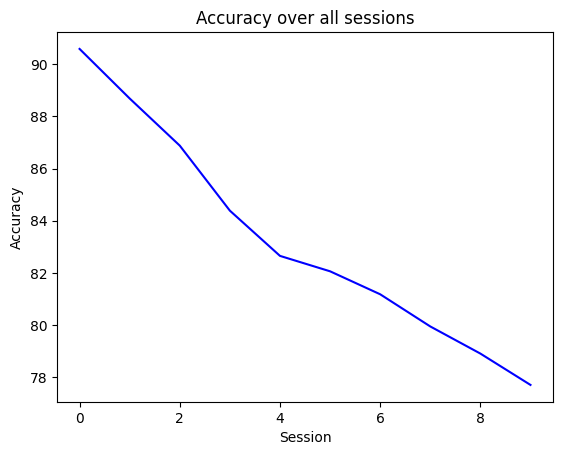

In [47]:
# variable to store accuracy
acc = []
acc_new_classes = []

# Iteration over incremental sessions
for session, (support, query, query_classes) in enumerate(few_shot_dataloader):
    print(f"Session: {session+1}")

    ### Computing new Prototypical Weights ###
    data = None

    for X_shot, y_shot in support:
        if data is None:
            data = X_shot
            target = y_shot
        else:
            data = torch.cat((data,X_shot), 0)
            target = torch.cat((target,y_shot), 0)

    data, target = encode((data.to(device), target.to(device)))
    data = data.squeeze()

    new_classes = y_shot.tolist()
    Nways = len(y_shot) # Number of ways, should always be 10

    if SPIKING:
        features = eval_model.net.snn[0](data)
        features = eval_model.net.snn[1](features)

        for index, class_id in enumerate(new_classes):
            mean = torch.sum(features[[i*Nways+index for i in range(NUM_SHOTS)]], dim=[0,1])/NUM_SHOTS
            eval_model.net.snn[-1].W.weight.data[class_id] = 2*mean
            eval_model.net.snn[-1].W.bias.data[class_id] = -torch.matmul(mean, mean.t())/(features.shape[1])
    else:
        features = eval_model.net.embedder(data)

        for index, class_id in enumerate(new_classes):
            mean = torch.sum(features[[i * Nways + index for i in range(NUM_SHOTS)]], dim=0) / NUM_SHOTS
            eval_model.net.fc.weight.data[class_id] = 2 * mean
            eval_model.net.fc.bias.data[class_id] = -torch.matmul(mean, mean.t())


    ### Testing phase ###
    eval_model.net.eval()

    # Define session dataloaders for query and query + base_test samples
    query_loader = DataLoader(query, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    full_session_test_set = ConcatDataset([base_test_set, query])
    full_session_test_loader = DataLoader(full_session_test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    # Create a mask function to only consider accuracy on classes presented so far
    session_classes = torch.cat((torch.arange(0,100, dtype=int), torch.IntTensor(query_classes)))
    mask = torch.full((200,), float('inf')).to(device)
    mask[session_classes] = 0
    out_mask = lambda x: x - mask

    # Run benchmark on query classes only
    query_results = benchmark_new_classes.run(dataloader = query_loader, postprocessors=[out_mask, F.softmax, out2pred, torch.squeeze])
    print(f"Accuracy on new classes: {query_results['classification_accuracy']*100} %")

    # Run benchmark to evaluate accuracy of this specific session
    session_results = benchmark_all_test.run(dataloader = full_session_test_loader, postprocessors=[out_mask, F.softmax, out2pred, torch.squeeze])
    print(f"Session accuracy: {session_results['classification_accuracy']*100} %")
    print("Session results:", session_results)
    acc.append(session_results['classification_accuracy'] * 100)
    acc_new_classes.append(query_results['classification_accuracy'] * 100)


print(f"Accuracy over all sessions: {acc}")

print(acc)
import matplotlib.pyplot as plt
plt.plot(acc, color='blue')
# plt.plot(acc_given_data_set, color='red')
plt.ylabel('Accuracy')
plt.xlabel('Session')
plt.title('Accuracy over all sessions')

plt.show()

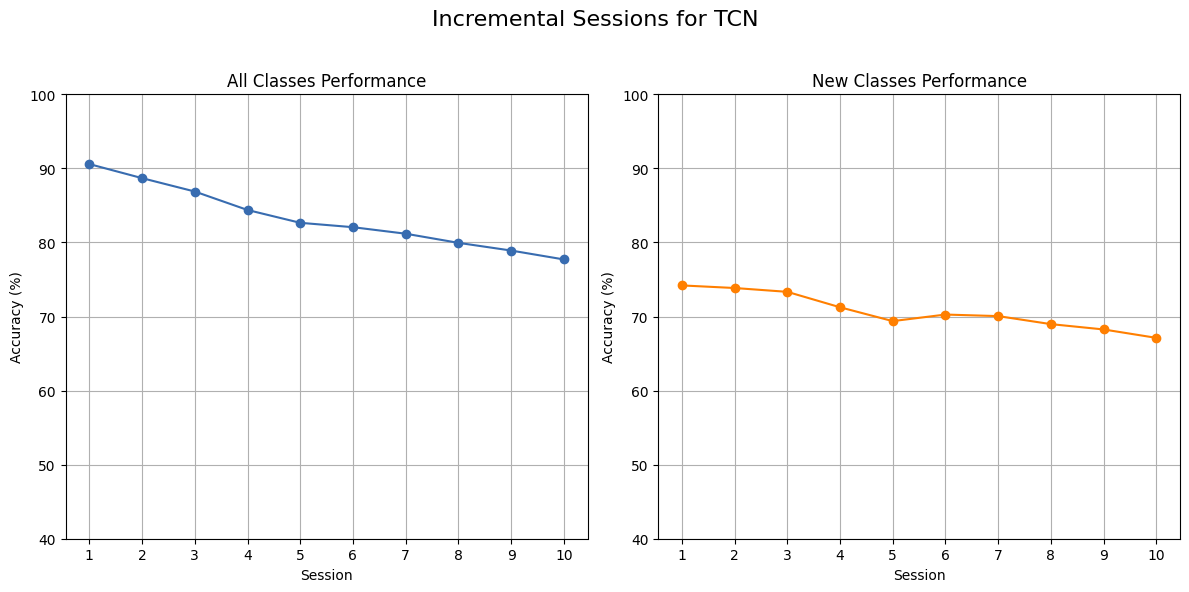

In [58]:
import matplotlib.pyplot as plt
import numpy as np

sessions = np.arange(1, 11, 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(sessions, acc, "-o", color="#386cb0")
axs[0].set_xticks(sessions)
axs[0].set_ylim((40, 100))
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_xlabel('Session')
axs[0].set_title('All Classes Performance')
axs[0].grid(True)

axs[1].plot(sessions, acc_new_classes, "-o", color="#ff7f00")
axs[1].set_xticks(sessions)
axs[1].set_ylim((40, 100))
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_xlabel('Session')
axs[1].set_title('New Classes Performance')
axs[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.90])
fig.suptitle('Incremental Sessions for TCN', fontsize=16)

plt.savefig("outputs/TCN_performance_plots.png", dpi=300)

plt.show()


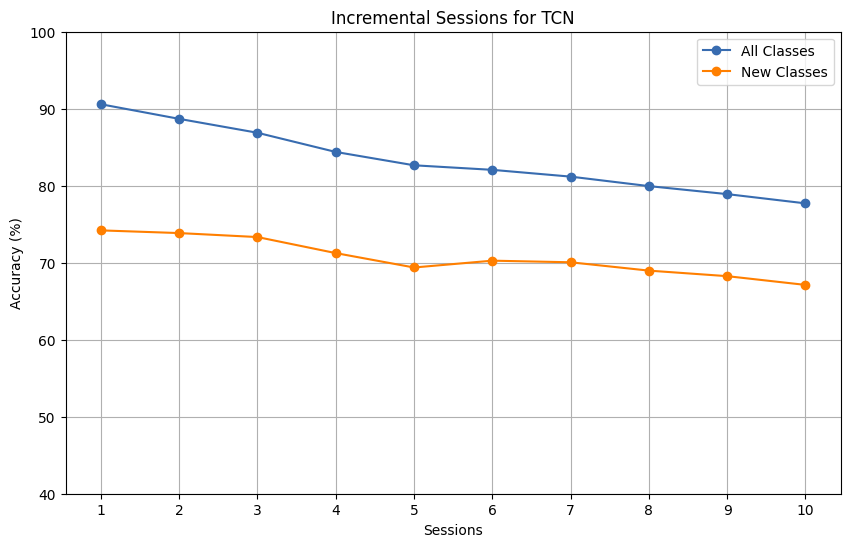

In [57]:
sessions = np.arange(1, 11, 1)

plt.figure(figsize=(10, 6))

plt.plot(sessions, acc, "-o", color="#386cb0", label='All Classes')

plt.plot(sessions, acc_new_classes, "-o", color="#ff7f00", label='New Classes')

plt.xticks(sessions)

plt.ylim((40, 100))

plt.ylabel('Accuracy (%)')
plt.xlabel('Sessions')
plt.title('Incremental Sessions for TCN')

plt.grid(True)
plt.legend()
plt.savefig("outputs/TCN_performance_plot2.png", dpi=300)
plt.show()
